In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt 
from numba import njit
from scipy.signal import find_peaks

plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

In [2]:
##### function creating opinion distribution #####
def opinion_dist(N, dist_type, dist_params):
    
    if dist_type == 'normal':
        exp_value = dist_params[0]
        std_deviation = dist_params[1]
        opinion = np.random.normal(exp_value, std_deviation, N) 
        return opinion
    elif dist_type == 'uniform':
        lower_border = dist_params[0]
        upper_border = dist_params[1]
        opinion = np.random.uniform(lower_border, upper_border, N) 
        return opinion
    elif dist_type == 'beta':
        alpha = dist_params[0]
        beta = dist_params[1]
        opinion = (np.random.beta(alpha, beta, N)-0.5)*2 
        return opinion
    else:
        print('unknown dist_type "%s"' %dist_type)
        return

    
##### opinion rule weight functions #####

##### assimilative influence #####
@njit
def f_1(opinion_a, opinion_b, epsilon, mu):
    return mu

##### similarity biased influence #####
@njit
def f_2(opinion_a, opinion_b, epsilon, mu):
    dist = abs(opinion_a - opinion_b)
    
    if dist <= epsilon:
        return mu
    else:
        return 0
    
##### repulsive influence #####
@njit
def f_3(opinion_a, opinion_b, epsilon, mu):
    dist = abs(opinion_a - opinion_b)
    weight = mu*(1-1/epsilon*dist)
    return weight

@njit
def f_4(opinion_a, opinion_b, epsilon, mu):
    
    a = 1
    r = 1
    Omega = 1
    
    dist = abs(opinion_a - opinion_b)
    
    if dist <= epsilon:
        return mu*(1 - (1/epsilon)*dist)**a
    elif dist <= Omega:
        return -mu/r*((1/epsilon)*dist-1)**a
    else:
        return 0


##### ricker wavelet function #####
@njit
def RW(opinion_a, opinion_b, epsilon, mu):
    dist = abs(opinion_a - opinion_b)
    
    return mu * (1 - (dist/epsilon)**2) * np.exp(-0.5*(dist/epsilon)**2)
    
    
##### opinion truncating function #####
@njit    
def trunc_opinion(opinion):

    if opinion < 0:
        new_opinion = 0
    elif opinion > 1:
        new_opinion = 1
    else:
        new_opinion = opinion
    
    return new_opinion
    
    
##### opinion dynamics ##### 
@njit
def opinion_dynamics(simulation_time, opinion_dist, post_dist, f, epsilon, mu, N_timeline, freq_step):
    
    opinion_timeline = np.zeros((N_timeline, int(simulation_time/freq_step)))
    
    for i in range(simulation_time):
        a = np.random.randint(0, len(opinion_dist))
        b = np.random.randint(0, len(post_dist))
        opinion_a = opinion_dist[a]
        opinion_b = post_dist[b]
        
        opinion_dist[a] += f(opinion_a, opinion_b, epsilon, mu) * (opinion_b-opinion_a)
        opinion_a = opinion_dist[a]
        opinion_dist[a] = trunc_opinion(opinion_a)
        
        if i%freq_step == 0:
            
            for k in range(N_timeline):
                opinion_timeline[k, int(i/freq_step)] = opinion_dist[k]
        
    return opinion_dist, opinion_timeline

def peak_finder(data, n_bins):
    hist, bins = np.histogram(data, density=True, bins=n_bins)
    peaks, properties = find_peaks(hist, height=0.25, distance=int(n_bins/5), threshold=None, width=None)
    midpoint = (bins[1]-bins[0])/2
    peaks_y = hist[peaks]
    peaks_x = bins[peaks]+midpoint
    n_peaks = len(peaks)
    
    if hist[0] > 0.25:
         
        if n_peaks == 0:
            peaks_y = np.concatenate((peaks_y, np.array([hist[0]])), axis=0) 
            peaks_x = np.concatenate((peaks_x, np.array([bins[0]+midpoint])), axis=0) 
            peaks = np.concatenate((peaks, np.array([0])), axis=0)
            n_peaks += 1
            
        elif peaks[0] > int(n_bins/5):
            peaks_y = np.concatenate((peaks_y, np.array([hist[0]])), axis=0) 
            peaks_x = np.concatenate((peaks_x, np.array([bins[0]+midpoint])), axis=0) 
            n_peaks += 1
        
    if hist[-1] > 0.25:
        
        if n_peaks == 0:
            peaks_y = np.concatenate((peaks_y, np.array([hist[-1]])), axis=0) 
            peaks_x = np.concatenate((peaks_x, np.array([bins[-1]+midpoint])), axis=0) 
            n_peaks += 1
        
        elif peaks[-1] < (n_bins-int(n_bins/5)):
            peaks_y = np.concatenate((peaks_y, np.array([hist[-1]])), axis=0) 
            peaks_x = np.concatenate((peaks_x, np.array([bins[-1]-midpoint])), axis=0) 
            n_peaks += 1
    
    return peaks_x, peaks_y, n_peaks

@njit
def convergence_check(opinions, thres):
    count = 0
    
    for i in range(len(opinions)):
        mean = np.mean(opinions)
        
        if abs(opinions[i]-mean) > thres: 
            count += 1
            
    return count

In [3]:
##### analyse convergence speed #####

In [4]:
N = 100
epsilon = 0.5
mu = 0.1
freq_step = 2

times = np.zeros(10)

for i in range(10):
    N = 100*(i+1)
    opinions = np.random.normal(0.5, 0.1, N)
    
    for k in range(N):
        while opinions[k] > 1 or opinions[k] < 0:
            opinions[k] = np.random.normal(0, 0.1)
            
    t = 0
    
    while convergence_check(opinions, 0.001) != 0:
        opinions, timeline = opinion_dynamics(1, opinions, opinions, f_3, epsilon, mu, N, freq_step)
        t += 1
       
    print('success')
    times[i] = t

success
success
success
success


KeyboardInterrupt: 

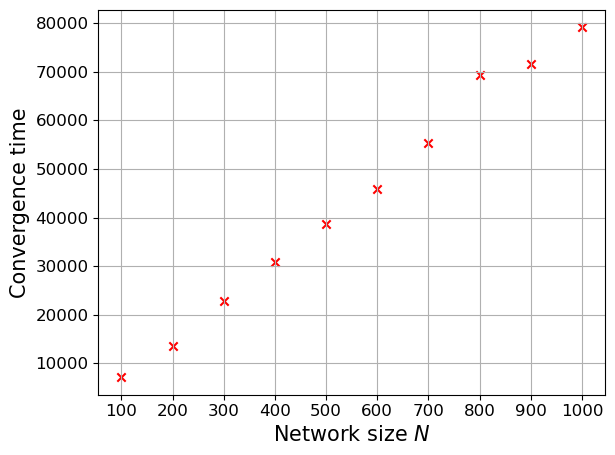

In [10]:
plt.figure()
plt.scatter(np.linspace(100,1000,10), times, marker='x', color='red')
plt.xticks(np.linspace(100,1000,10))
plt.grid()
plt.xlabel(r'Network size $N$')
plt.ylabel('Convergence time')
#plt.savefig('convergence_speed_N.png', dpi=200, bbox_inches='tight')
plt.tight_layout()

In [142]:
N = 100
epsilon = 0.5
freq_step = 10**3

times = np.zeros(100)

for i in range(100):
    mu = 0.01*(i+1)
    opinions = np.random.normal(0.5, 0.1, N)
    
    for k in range(N):
        while opinions[k] > 1 or opinions[k] < 0:
            opinions[k] = np.random.normal(0, 0.1)
            
    t = 0
    
    while convergence_check(opinions, 0.001) != 0:
        opinions, timeline = opinion_dynamics(1, opinions, opinions, f_3, epsilon, mu, N, freq_step)
        t += 1
        
    if i%10==0:   
        print('success')
    times[i] = t

success
success
success
success
success
success
success
success
success
success


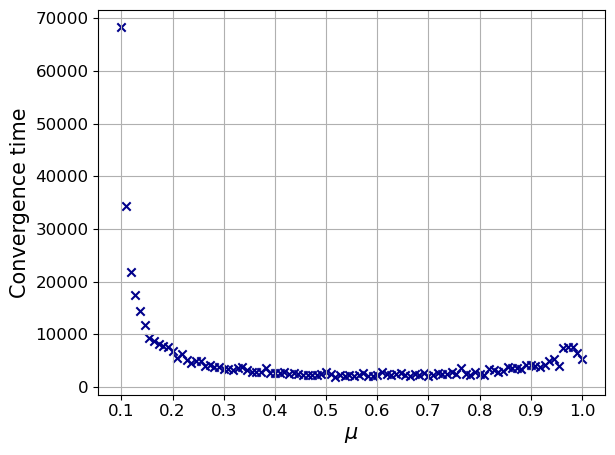

In [143]:
plt.figure()
plt.scatter(np.linspace(0.1,1,100), times, marker='x', color='darkblue')
plt.grid()
plt.xlabel(r'$\mu$')
plt.ylabel('Convergence time')
plt.xticks(np.linspace(0.1,1,10))
#plt.savefig('convergence_speed_mu.png', dpi=200, bbox_inches='tight')
plt.tight_layout()